# BBC Article Categorization Project

In this project, I seek to employ the matrix facorization techniques on the BBC news articles data to successfully categorize the articles by topic.

In [47]:
!where python

C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\python.exe


In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import itertools

In [51]:
# Load the data
train = pd.read_csv(r"Data/BBC News Train.csv")
test = pd.read_csv(r"Data/BBC News Test.csv")

## Step 1: Exploratory Data Analysis

In [52]:
# Inspect the data
print(f'Training data sample is: \n{train.head()}')
print(f'Test data sample is: \n{test.head()}')

Training data sample is: 
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
Test data sample is: 
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [53]:
# Get data info
print('\nData Information:')
print('Training info is:\n')
train.info()
print('\nTesting info is:\n')
test.info()


Data Information:
Training info is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB

Testing info is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [54]:
# Retrieve Descriptions of Data
print('\nDescription of the training data:\n')
print(train.describe(include='all'))
print('\nDescription of the testing data:\n')
print(test.describe(include='all'))


Description of the training data:

          ArticleId                                               Text  \
count   1490.000000                                               1490   
unique          NaN                                               1440   
top             NaN  t-mobile bets on  pocket office  t-mobile has ...   
freq            NaN                                                  2   
mean    1119.696644                                                NaN   
std      641.826283                                                NaN   
min        2.000000                                                NaN   
25%      565.250000                                                NaN   
50%     1112.500000                                                NaN   
75%     1680.750000                                                NaN   
max     2224.000000                                                NaN   

       Category  
count      1490  
unique        5  
top       sport  
fre

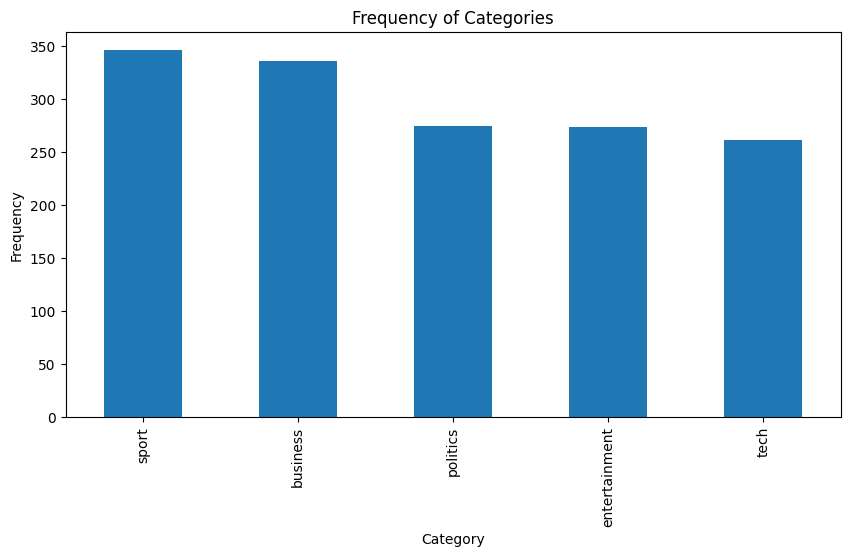

In [55]:
# Make a bar plot of category data
plt.figure(figsize=(10,5))
cat_plot = train['Category'].value_counts()
cat_plot.plot(kind='bar')
plt.title('Frequency of Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

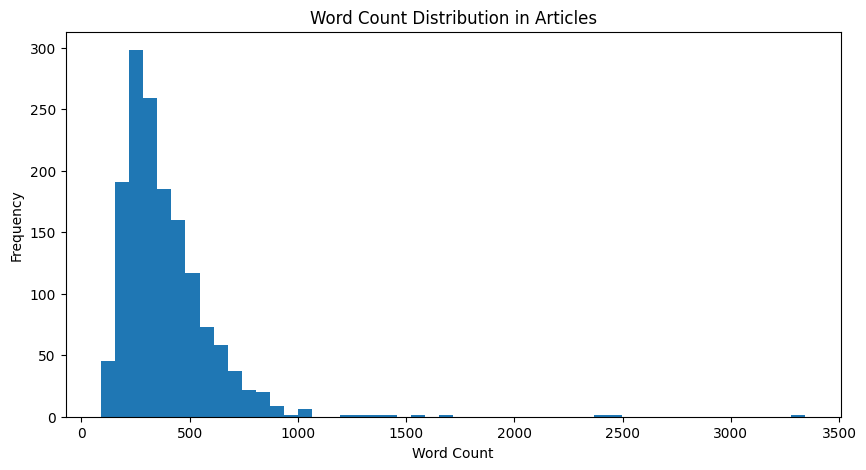

In [56]:
# Plot word count distribution from the articles
plt.figure(figsize=(10,5))
train['Word Count'] = train['Text'].apply(lambda x: len(x.split()))
train['Word Count'].plot(kind='hist', bins=50, title='Word Count Distribution in Articles')
plt.xlabel('Word Count')
plt.show()

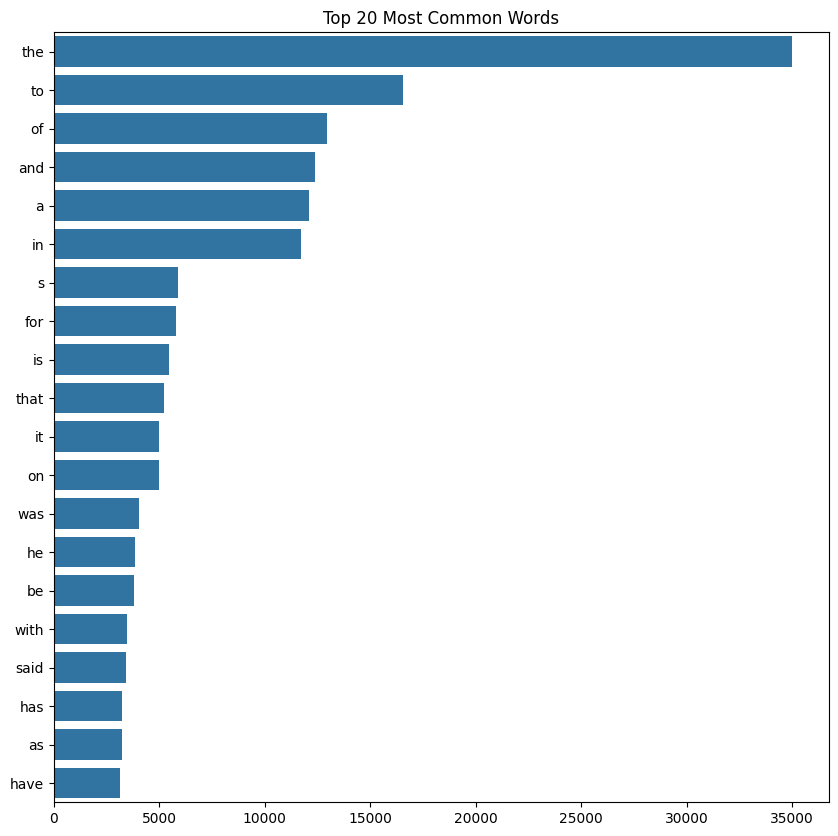

In [57]:
# Plot word Frequency
plt.figure(figsize=(10,10))
words = ' '.join(train['Text']).split()
word_freq = Counter(words)
common_words = word_freq.most_common(20)

sns.barplot(x=[item[1] for item in common_words], y=[item[0] for item in common_words])
plt.title('Top 20 Most Common Words')
plt.show()

### Step 1.1 Data Cleaning Procedures

Here I will transform the text and category data from object data types to string data types, so that these data are easier to process.

In [58]:
# Convert train and test data to more useful data types
train = train.convert_dtypes()
test = test.convert_dtypes()
print('Train info:\n')
train.info()
print('\nTest info:\n')
test.info()

Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1490 non-null   Int64 
 1   Text        1490 non-null   string
 2   Category    1490 non-null   string
 3   Word Count  1490 non-null   Int64 
dtypes: Int64(2), string(2)
memory usage: 49.6 KB

Test info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    Int64 
 1   Text       735 non-null    string
dtypes: Int64(1), string(1)
memory usage: 12.3 KB


### Step 1.2 Plan of Analysis

My plan to analyze the cleaned data is to process the raw texts via TF-IDF to create a matrix representation of the article data. TF-IDF measures how frequent a term is in an article versus how often the word appears across the dataset. This is why it is called "Term Frequency - Inverse Document Frequency". This will minimize the affect of common words like "the" dominating the model's learning.

After I convert the raw texts into matrix form, I then plan on creating a Non-negative matrix factorization model to extract the topics of the articles.

In [59]:
# Create tfidf model
tfidf_vectorizer = TfidfVectorizer()
tfidf_mat = tfidf_vectorizer.fit_transform(train['Text'])

## Step 2: Building and Training Models

Here I build a NMF model to extract the topics of the articles.

In [60]:
# Create NMF model
nmf_model = NMF(n_components = 5)
document_topic_mat = nmf_model.fit_transform(tfidf_mat)
topic_word_mat = nmf_model.components_
model_topics = nmf_model.get_feature_names_out()

# Print results of model
print(f'model topics are:\n{model_topics}')
print(f'\ntopic-word matrix:\n{topic_word_mat}')
print(f'\ndocument-topic matrix:\n{document_topic_mat}\n')

# Print the top words associated with each topic
n_top_words = 20
for topic_idx, topic in enumerate(topic_word_mat):
    print(f"Topic #{topic_idx}:")
    print(", ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Record the topic predictions of the model for each article
pred_topics = document_topic_mat.argmax(axis=1)
print(f'\npredicted topics for each document are:\n{pred_topics}')

model topics are:
['nmf0' 'nmf1' 'nmf2' 'nmf3' 'nmf4']

topic-word matrix:
[[0.00045443 0.10382443 0.00012894 ... 0.00043003 0.00029464 0.        ]
 [0.00072949 0.04094477 0.00018615 ... 0.         0.         0.        ]
 [0.00062309 0.         0.00026076 ... 0.00870915 0.00036356 0.00506914]
 [0.00051802 0.02113789 0.         ... 0.         0.00136904 0.00112964]
 [0.0010105  0.06275728 0.00045488 ... 0.         0.         0.        ]]

document-topic matrix:
[[0.04483736 0.04604301 0.00818059 0.         0.00215902]
 [0.15117448 0.         0.         0.         0.        ]
 [0.11501211 0.02017466 0.01394144 0.00982976 0.03496789]
 ...
 [0.1442115  0.         0.00290976 0.         0.        ]
 [0.0427903  0.         0.         0.01018742 0.18596309]
 [0.02812511 0.         0.00929831 0.0023621  0.10197761]]

Topic #0:
the, in, of, to, and, its, us, growth, said, economy, that, year, it, by, for, is, on, has, sales, bank
Topic #1:
the, mr, to, he, labour, election, blair, of, and, party

In [61]:
# Figure out the feature names that match the actual topics
topic_names = sorted(set(train['Category']))
topic_map_find_label = {i:topic for i,topic in enumerate(topic_names)}

def find_topic_order(true_labels, pred_labels):
    best_perm = None
    best_accuracy = 0
    for perm in itertools.permutations(range(5)):
        model_pred = [topic_map_find_label[perm[label]] for label in pred_labels]
    
        acc = accuracy_score(true_labels, model_pred)
    
        if acc > best_accuracy:
            best_accuracy = acc
            best_perm = perm
    return best_perm, best_accuracy

best_perm, best_accuracy = find_topic_order(train['Category'], pred_topics)
print(best_accuracy)

0.876510067114094


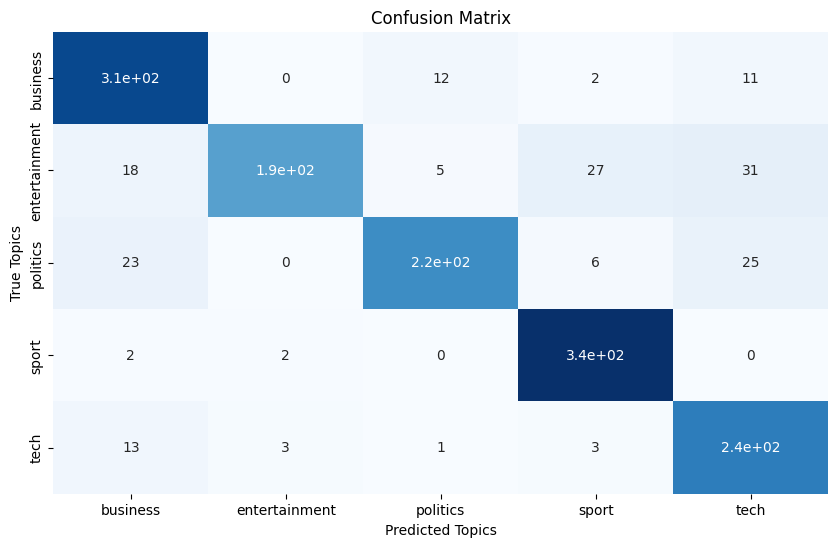

In [62]:
# Create a confusion matrix
best_model = [topic_map_find_label[best_perm[label]] for label in pred_topics]
cm = confusion_matrix(train['Category'], best_model)
unique_labels = np.unique(train['Category'])
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel('Predicted Topics')
plt.ylabel('True Topics')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Kody.Morrison\AppData\Local\Programs\Python\Python312\Lib\site-

Best accuracy is 0.8516778523489933 with max_features set to 1450


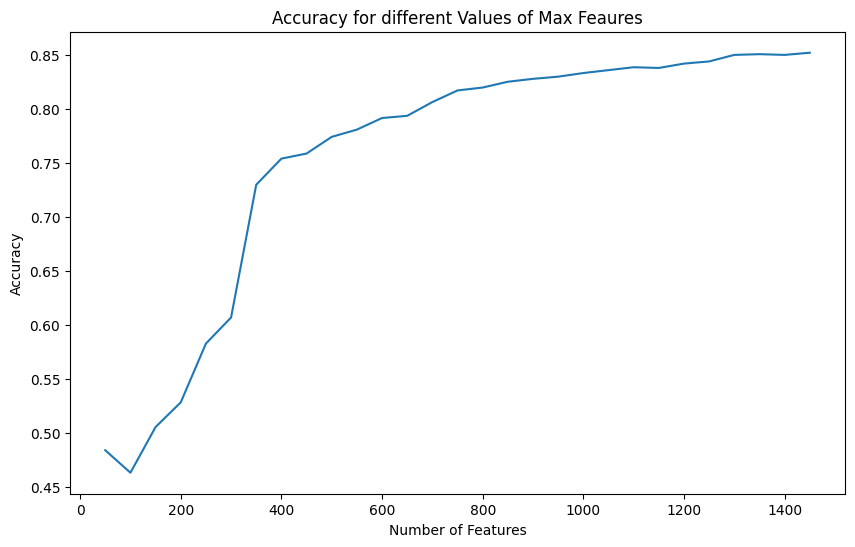

In [63]:
# Adjust Hyperparameters and rebuild model
best_max_feat = None
best_accuracy_wrt_max_feat = 0
accuracy_list = []
num_feat_list = []
for num in range(50, 1500, 50):
    # Create Word Embedding
    tfidf_vectorizer = TfidfVectorizer(max_features = num)
    tfidf_mat = tfidf_vectorizer.fit_transform(train['Text'])

    # Train NMF Model
    document_topic_mat = nmf_model.fit_transform(tfidf_mat)
    topic_word_mat = nmf_model.components_
    model_topics = nmf_model.get_feature_names_out()
    pred_topics = document_topic_mat.argmax(axis=1)

    _, acc = find_topic_order(train['Category'], pred_topics)
    accuracy_list.append(acc)
    num_feat_list.append(num)
    if acc > best_accuracy_wrt_max_feat:
        best_accuracy_wrt_max_feat = acc
        best_max_feat = num
print(f'Best accuracy is {best_accuracy_wrt_max_feat} with max_features set to {best_max_feat}')

# Make line graph
plt.figure(figsize=(10,6))
plt.plot(num_feat_list, accuracy_list, label = 'Line')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy for different Values of Max Feaures')
plt.show()

### Initial Analysis

So far, setting the tfidf model to include all of the word features, rather than restricting it include a certain number of maximum features, produced the most accurate model. To improve the model, I will now seek to use different hyperparameters in my tfidf model to improve the accuracy. Mainly I will seek to change the max_df and min_df to different values, which elimates features that occur over max_df/under min_df. In addition to this, I am going to further split the training data and perform k-fold cross validation and see how my model performs to test overfitting.

In [64]:
# Create tfidf model
tfidf_vectorizer = TfidfVectorizer(max_df=160, min_df=5, sublinear_tf=True, ngram_range=(1,2), stop_words='english', norm = 'l2')
tfidf_mat = tfidf_vectorizer.fit_transform(train['Text'])

# Create NMF model
document_topic_mat = nmf_model.fit_transform(tfidf_mat)
topic_word_mat = nmf_model.components_
model_topics = nmf_model.get_feature_names_out()

pred_topics = document_topic_mat.argmax(axis=1)
label_order, acc = find_topic_order(train['Category'], pred_topics)
print(acc)

# Print the top words associated with each topic
n_top_words = 10
for topic_idx, topic in enumerate(topic_word_mat):
    print(f"Topic - {topic_map_find_label[label_order[topic_idx]]}:")
    print(", ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

0.961744966442953
Topic - sport:
cup, match, season, coach, injury, club, ireland, chelsea, league, france
Topic - politics:
labour, election, blair, party, mr blair, prime, prime minister, brown, tories, tory
Topic - tech:
users, technology, mobile, software, digital, phone, net, microsoft, online, internet
Topic - business:
growth, economy, economic, bank, shares, oil, prices, analysts, sales, rise
Topic - entertainment:
awards, actor, award, oscar, star, actress, films, comedy, nominated, stars


In [65]:
# K-fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = np.array([])

for train_index, test_index in kf.split(tfidf_mat):
    # Convert the indices to integer arrays
    X_train, X_test = tfidf_mat[train_index], tfidf_mat[test_index]
    
    # Train the NMF model on the training data
    document_topic_mat = nmf_model.fit_transform(X_train)
    pred_topics = document_topic_mat.argmax(axis=1)
    _, acc = find_topic_order(train['Category'].iloc[train_index], pred_topics)
    scores = np.append(scores, acc)
    
    # Train the NMF model on the testing data
    document_topic_mat = nmf_model.fit_transform(X_test)
    pred_topics = document_topic_mat.argmax(axis=1)
    _, acc = find_topic_order(train['Category'].iloc[test_index], pred_topics)
    scores = np.append(scores, acc)

# Print the average accuracy across all folds
print(f'Accuracy Scores from K-Fold CV is:\n{scores}')
print(f'\nAverage of Scores from CV:\n{np.mean(scores)}')

Accuracy Scores from K-Fold CV is:
[0.95889262 0.94630872 0.96644295 0.94295302 0.95637584 0.93624161
 0.96224832 0.73489933 0.95637584 0.92281879]

Average of Scores from CV:
0.9283557046979866


### Application to Test Data

Now that I've found the best model on the training data and verified it's flexibility/bias via k-fold cv, I will now apply the model to the test data and submit to kaggle to determine how my model performed on the test data. Based off the cross validation, I expect my results to be at least 90%.

In [66]:
# Apply best model to the test data
#tfidf_vectorizer_te = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), stop_words='english', norm = 'l2', max_df=160, min_df=5)
tfidf_mat_te = tfidf_vectorizer.fit_transform(test['Text'])
document_topic_mat_te = nmf_model.fit_transform(tfidf_mat_te)
topic_word_mat_te = nmf_model.components_
# Find the top words associated with the topics
num_top_words_te = 10
for topic_index, topic in enumerate(topic_word_mat_te):
    print(f'Topic Number: {topic_index}')
    print(", ".join(tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_top_words_te-1:-1]))

Topic Number: 0
technology, users, digital, computer, use, mobile, net, using, software, access
Topic Number: 1
game, win, match, team, play, cup, england, players, injury, coach
Topic Number: 2
labour, election, party, blair, government, howard, minister, tory, mr blair, brown
Topic Number: 3
growth, economy, 2004, market, bank, sales, company, prices, economic, oil
Topic Number: 4
film, award, awards, best, actress, prize, oscar, festival, won, music


In [67]:
# Since I don't have true labels to order the actual topics, I manually do it here based on the above data
topic_map_te = {0: "tech", 1:"sport", 2:"politics", 3:"business", 4:"entertainment"}
model_pred_te = document_topic_mat_te.argmax(axis = 1)
model_pred_te_labels = [topic_map_te[label] for label in model_pred_te]
# Create Submission File for Unsupervised Algo
final_submission = test.drop('Text', axis=1)
final_submission['Category'] = model_pred_te_labels
final_submission.to_csv('Kaggle_Test_Pred_Morrison_Unsup.csv', index=False)

## Step 3: Compare with Supervised Models

In order to compare the Unsupervised Model to Supervised ones, I will train Support Vector Machine and Logistic Regression Models

In [68]:
# Create supervised features
X_train_sup = tfidf_vectorizer.fit_transform(train['Text'])
X_test_sup = tfidf_vectorizer.transform(test['Text'])
# Scale data
scaler = StandardScaler(with_mean=False)
X_train_sup = scaler.fit_transform(X_train_sup)
# Create Models
svc_model = SVC(kernel='linear', gamma=5)
log_reg_model = LogisticRegression()
# Use CV to determine better model
models = [svc_model, log_reg_model]
for model in models:
    scores = cross_val_score(model, X_train_sup, train['Category'], cv=5, scoring='accuracy')
    print(f'CV scores for {model} are {scores}. Avg is {scores.mean()}')

CV scores for SVC(gamma=5, kernel='linear') are [0.97986577 0.96644295 0.97651007 0.98322148 0.98322148]. Avg is 0.9778523489932887
CV scores for LogisticRegression() are [0.98322148 0.96979866 0.97986577 0.98657718 0.98322148]. Avg is 0.9805369127516779


### Supervised Analysis

Based on my CV scores, I will upload my test prediciton results using the LogisticRegressor model with scaled data

In [69]:
# Create a Kaggle submission using the logreg model
X_test_sup = scaler.fit_transform(X_test_sup)
log_reg_model.fit(X_train_sup, train['Category'])
y_pred = log_reg_model.predict(X_test_sup)

final_sub_sup = test.drop('Text', axis=1)
final_sub_sup['Category'] = y_pred
final_sub_sup.to_csv('Kaggle_Test_Pred_Morrison_Sup.csv', index=False)

### Comparing Supervised and Unsupervised Models

Comparing my CV scores with the NMF, SCV, and LogReg models, it appears that the LogisticRegressor is the most data efficient. On average, the LogReg was 98.1% accurate across the folds whereas SVC and NMF were 97.8% and 92.8% accurate, respectively. Due to the model's accuracy and the principle of Occam's Razor, the Logistic Regressor model should be preferred over the other two models. It is more accurate than the other models, and it is a low-complexity model.

In addition to the CV, my Unsupervised Model scored a 95.2% in accuracy and my Supervised Model (LogReg) scored 98.5% in accuracy in the Kaggle competition. This demonstrates that the models did not overfit the data, since they were able to generalize well with the test data.

Overall, I love when a simple solution performs outstanding when solving a problem!

## References
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html